In [1]:
import io, requests

import pandas as pd

URL_TEMPLATE = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_%s_global.csv'
def url2df(url,typ):
    content = requests.get(url%typ).content
    df = pd.read_csv(io.StringIO(content.decode('utf-8')))
    print((typ,df.shape))
    return df
typ2df = dict((typ,url2df(URL_TEMPLATE,typ)) for typ in ['confirmed','deaths'])
typ2df['deaths'].sample(3)

('confirmed', (253, 71))
('deaths', (253, 71))


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
190,NaN,Saint Vincent and the Grenadines,12.9843,-61.2872,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,NaN,Senegal,14.4974,-14.4524,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,Mayotte,France,-12.8275,45.1662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
KVS_ID = {
  'Country/Region':'nation',
  'Province/State':'state',
  'Lat':'lat',
  'Long':'lon',
  }
def r2c(df,groupby_nation=True):
  df = (df
    .rename(columns=KVS_ID)
    .drop(['lat','lon'],axis='columns')
     )
  if groupby_nation:
    return (df
      .drop('state',axis='columns')
      .groupby('nation')
      .agg(sum)
      .T
      )
  else:
    return (df
      .set_index(['nation','state'])
      .T
      )

nations = ['China','Italy','US'
  ,'United Kingdom', 'Sweden',
#   ,'Spain','France','Germany'
  ]
df_cases = r2c(typ2df['confirmed'])[nations]
df_deaths = r2c(typ2df['deaths'])[nations]
df_cases.tail(5)

nation,China,Italy,US,United Kingdom,Sweden
3/24/20,81591,69176,53740,8164,2286
3/25/20,81661,74386,65778,9640,2526
3/26/20,81782,80589,83836,11812,2840
3/27/20,81897,86498,101657,14745,3069
3/28/20,81999,92472,121478,17312,3447


<Figure size 432x288 with 0 Axes>

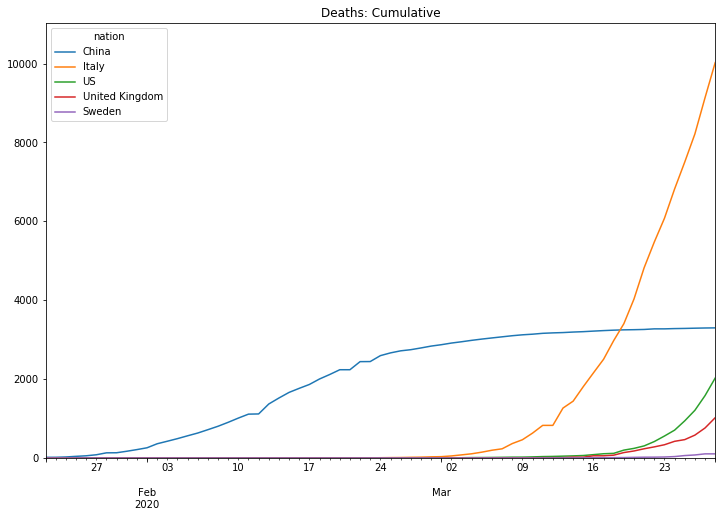

<Figure size 432x288 with 0 Axes>

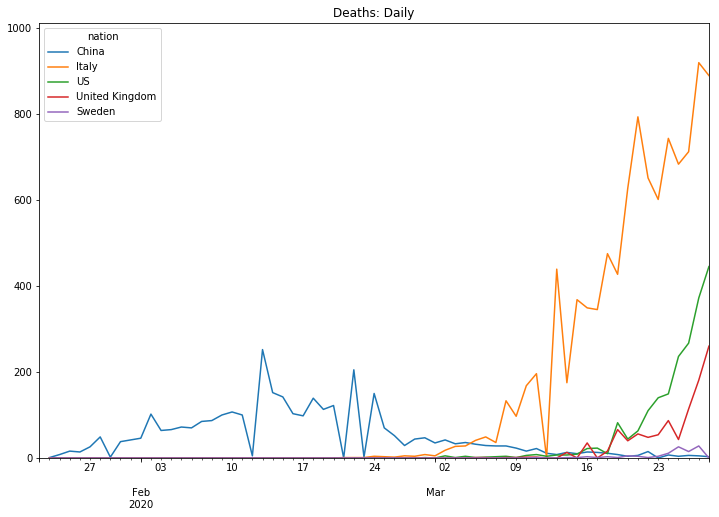

In [11]:
import matplotlib.pyplot as plt

def plot(df,title=''):
  plt.figure()
  df.index = pd.to_datetime(df.index)
  y_max = max(df.fillna(0.).max(axis=1)) * 1.1
  df.plot(
    figsize=(12,8),
    title=title,
    ylim=(0, y_max),
    xlim=(df.index[0], df.index[-1]),
    )
  plt.show()
plot(df_deaths,'Deaths: Cumulative')
df_d_deaths = df_deaths - df_deaths.shift(1)
plot(df_d_deaths,'Deaths: Daily')

<Figure size 432x288 with 0 Axes>

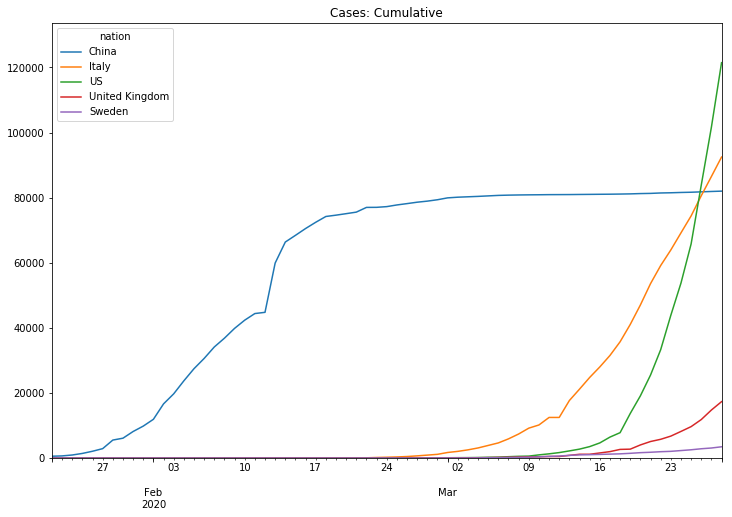

<Figure size 432x288 with 0 Axes>

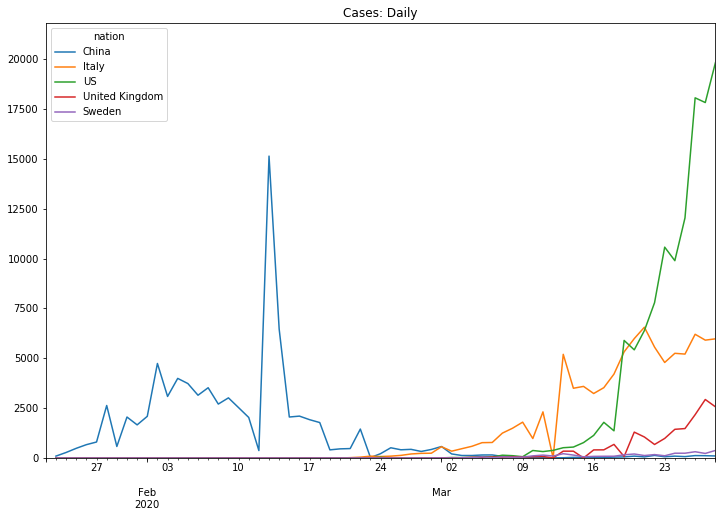

In [12]:
plot(df_cases,'Cases: Cumulative')
df_d_cases = df_cases - df_cases.shift(1)
plot(df_d_cases,'Cases: Daily')

nation      China  Italy    US  United Kingdom  Sweden  China  Italy      US  \
2020-03-24   3281   6820   706             423      36  81591  69176   53740   
2020-03-25   3285   7503   942             466      62  81661  74386   65778   
2020-03-26   3291   8215  1209             580      77  81782  80589   83836   
2020-03-27   3296   9134  1581             761     105  81897  86498  101657   
2020-03-28   3299  10023  2026            1021     105  81999  92472  121478   

nation      United Kingdom  Sweden  
2020-03-24            8164    2286  
2020-03-25            9640    2526  
2020-03-26           11812    2840  
2020-03-27           14745    3069  
2020-03-28           17312    3447  
nation         China     Italy        US  United Kingdom    Sweden
2020-03-24  0.040213  0.098589  0.013137        0.051813  0.015748
2020-03-25  0.040227  0.100866  0.014321        0.048340  0.024545
2020-03-26  0.040241  0.101937  0.014421        0.049103  0.027113
2020-03-27  0.040246  0.10559

<Figure size 432x288 with 0 Axes>

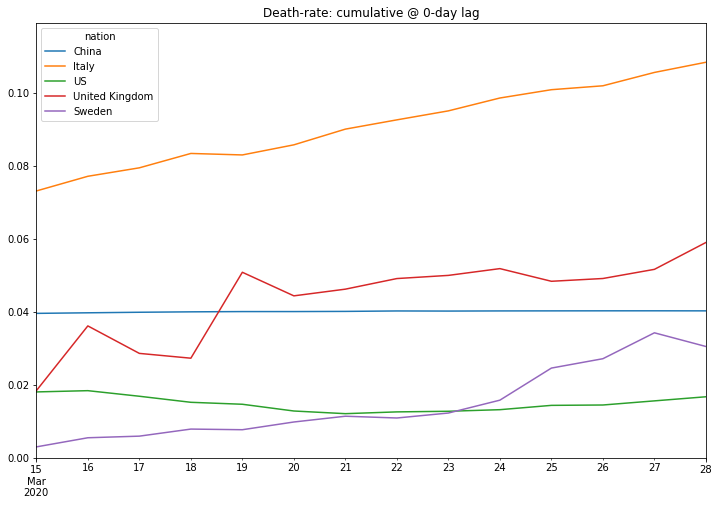

In [15]:
# Death-rate from cumulative w/ 0-day lag
T = 0
print(pd.concat([df_deaths, df_cases.shift(T)], axis='columns').tail(5))
df_rate_death = df_deaths / df_cases.shift(T)
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: cumulative @ %s-day lag'%T)

nation      China  Italy    US  United Kingdom  Sweden    China    Italy  \
2020-03-24   3281   6820   706             423      36  81058.0  31506.0   
2020-03-25   3285   7503   942             466      62  81102.0  35713.0   
2020-03-26   3291   8215  1209             580      77  81156.0  41035.0   
2020-03-27   3296   9134  1581             761     105  81250.0  47021.0   
2020-03-28   3299  10023  2026            1021     105  81305.0  53578.0   

nation           US  United Kingdom  Sweden  
2020-03-24   6421.0          1960.0  1190.0  
2020-03-25   7783.0          2642.0  1279.0  
2020-03-26  13677.0          2716.0  1439.0  
2020-03-27  19100.0          4014.0  1639.0  
2020-03-28  25489.0          5067.0  1763.0  
nation         China     Italy        US  United Kingdom    Sweden
2020-03-24  0.040477  0.216467  0.109952        0.215816  0.030252
2020-03-25  0.040505  0.210092  0.121033        0.176382  0.048475
2020-03-26  0.040552  0.200195  0.088397        0.213549  0.053509

<Figure size 432x288 with 0 Axes>

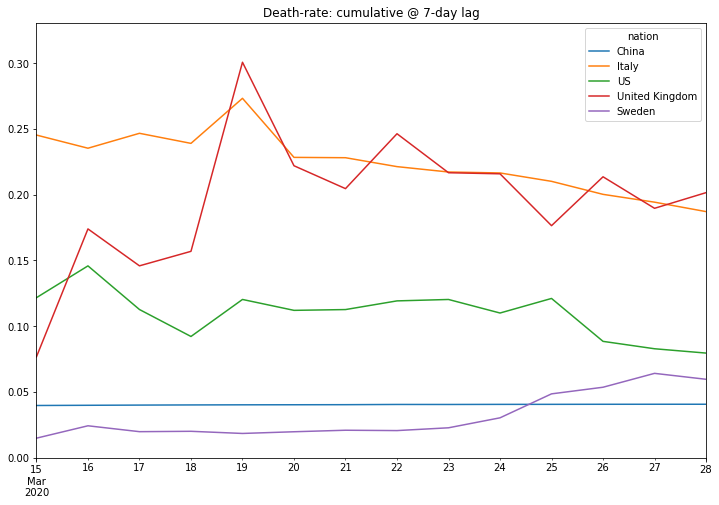

In [13]:
# Death-rate from cumulative w/ T-day lag
T = 7
print(pd.concat([df_deaths, df_cases.shift(T)], axis='columns').tail(5))
df_rate_death = df_deaths / df_cases.shift(T)
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: cumulative @ %s-day lag'%T)

nation      China  Italy     US  United Kingdom  Sweden  China   Italy  \
2020-03-24    7.0  743.0  149.0            87.0    11.0   25.0  3526.0   
2020-03-25    4.0  683.0  236.0            43.0    26.0   44.0  4207.0   
2020-03-26    6.0  712.0  267.0           114.0    15.0   54.0  5322.0   
2020-03-27    5.0  919.0  372.0           181.0    28.0   94.0  5986.0   
2020-03-28    3.0  889.0  445.0           260.0     0.0   55.0  6557.0   

nation          US  United Kingdom  Sweden  
2020-03-24  1789.0           409.0    87.0  
2020-03-25  1362.0           682.0    89.0  
2020-03-26  5894.0            74.0   160.0  
2020-03-27  5423.0          1298.0   200.0  
2020-03-28  6389.0          1053.0   124.0  
nation         China       Italy          US  United Kingdom     Sweden  \
2020-03-24  7.285714  616.714286   85.428571       52.428571   4.142857   
2020-03-25  6.285714  646.428571  117.714286       56.285714   7.428571   
2020-03-26  6.000000  687.142857  144.142857       63.142857

<Figure size 432x288 with 0 Axes>

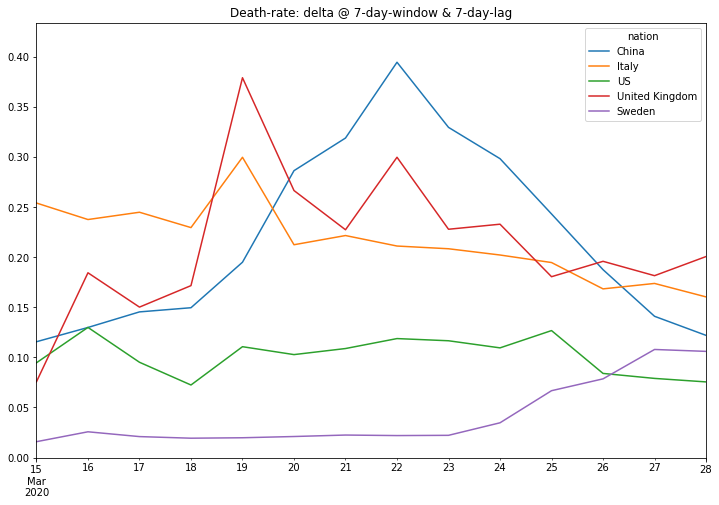

In [16]:
# Death-rate from delta w/ T-day lag
T = 7
W = 7
print(pd.concat([df_d_deaths, df_d_cases.shift(T)], axis='columns').tail(5))
print(pd.concat([df_d_deaths.rolling(W).mean(), df_d_cases.shift(T).rolling(W).mean()], axis='columns').tail(5))
df_rate_death = df_d_deaths.rolling(W).mean() / df_d_cases.shift(T).rolling(W).mean()
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: delta @ %s-day-window & %s-day-lag'%(W,T))